<a href="https://colab.research.google.com/github/Brandon56-code/ola_bike-ride-request/blob/main/Evaluating_Various_Model_Approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing libraries

In [ ]:
!pip install gdown

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [ ]:
import gdown

file_id = "1Qnpb1--5liNmMvxoe3iM6Rz4yJMkTDFH"
url = f"https://drive.google.com/uc?id={file_id}"

output = "dataset.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Qnpb1--5liNmMvxoe3iM6Rz4yJMkTDFH
To: /content/dataset.csv
100%|██████████| 648k/648k [00:00<00:00, 43.3MB/s]


'dataset.csv'

# load dataset


In [ ]:
# Load dataset (replace with your dataset path or df from earlier steps)
df = pd.read_csv("dataset.csv")

# Quick look at the dataset
print(df.head())
print(df.info())


              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-n

In [ ]:
# Define X (features) and y (target)

# Example: assuming target column is "temp"
X = df.drop(columns=["temp"])
y = df["temp"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (8708, 11)
Testing shape: (2178, 11)


In [ ]:
# Define models for comparison
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


In [ ]:
# Robust Cross-Validation (run this after X_train, X_test, y_train, y_test and models are defined)

import numpy as np
import pandas as pd
import traceback
from sklearn.model_selection import KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------
# Basic sanity checks
# -------------------------
if 'X_train' not in globals() or 'y_train' not in globals():
    raise NameError("X_train and y_train must be defined. Run the earlier cells that create them.")

if y_train.isnull().any():
    raise ValueError("y_train contains NaN values. Drop or impute them before training (targets cannot be null).")

# -------------------------
# Handle datetime columns (convert to numeric if present)
# -------------------------
import pandas as pd
dt_cols = [c for c in X_train.columns if pd.api.types.is_datetime64_any_dtype(X_train[c])]
if dt_cols:
    print("Converting datetime columns to epoch seconds:", dt_cols)
    # copy to avoid SettingWithCopyWarning
    X_train = X_train.copy()
    for c in dt_cols:
        X_train[c] = X_train[c].astype('int64') // 10**9
    if 'X_test' in globals():
        X_test = X_test.copy()
        for c in dt_cols:
            if c in X_test.columns:
                X_test[c] = X_test[c].astype('int64') // 10**9

# -------------------------
# Feature type detection
# -------------------------
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# -------------------------
# OneHotEncoder compatibility across sklearn versions
# -------------------------
try:
    # newer sklearn versions: sparse_output parameter
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    # older sklearn versions: sparse parameter
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# -------------------------
# Preprocessing pipelines (only include steps when columns exist)
# -------------------------
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

transformers = []
if numeric_features:
    transformers.append(('num', numeric_transformer, numeric_features))
if categorical_features:
    transformers.append(('cat', categorical_transformer, categorical_features))

if transformers:
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
else:
    # No preprocessing required (all features numeric and no NaNs)
    preprocessor = 'passthrough'

# -------------------------
# Build pipelines wrapping each model (so cross_val_score won't fail on raw strings/NaNs)
# -------------------------
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([('preprocessor', preprocessor), ('model', model)])

# -------------------------
# Run cross-validation
# -------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, pipeline in pipelines.items():
    try:
        scores = cross_val_score(
            pipeline,
            X_train,
            y_train,
            cv=cv,
            scoring='neg_mean_squared_error',   # stable scoring; we'll convert to RMSE
            n_jobs=-1
        )
        # protect against tiny negative rounding errors
        rmse_scores = np.sqrt(np.maximum(-scores, 0.0))
        results[name] = rmse_scores
        print(f"{name:20s} | folds RMSE: {np.round(rmse_scores, 4)} | mean = {rmse_scores.mean():.4f}, std = {rmse_scores.std():.4f}")
    except Exception as e:
        print(f"ERROR during CV for model '{name}':")
        traceback.print_exc()
        # do not add model to results if it failed

# Store results in DataFrame for downstream steps
if results:
    cv_results_df = pd.DataFrame(results)
else:
    cv_results_df = pd.DataFrame()
    print("No successful CV results. Check errors above.")


Numeric features: ['season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
Categorical features: ['datetime']
Linear Regression    | folds RMSE: [1.0532 1.3433 1.1075 1.2544 1.7016] | mean = 1.2920, std = 0.2293
Random Forest        | folds RMSE: [0.6197 0.8641 0.5824 0.6543 0.9734] | mean = 0.7388, std = 0.1527
Gradient Boosting    | folds RMSE: [0.5773 0.807  0.6077 0.6732 0.9782] | mean = 0.7287, std = 0.1477


# visualization of cross-validation results

/tmp/ipython-input-4161729721.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, patch_artist=True, medianprops={'linewidth':1.5})


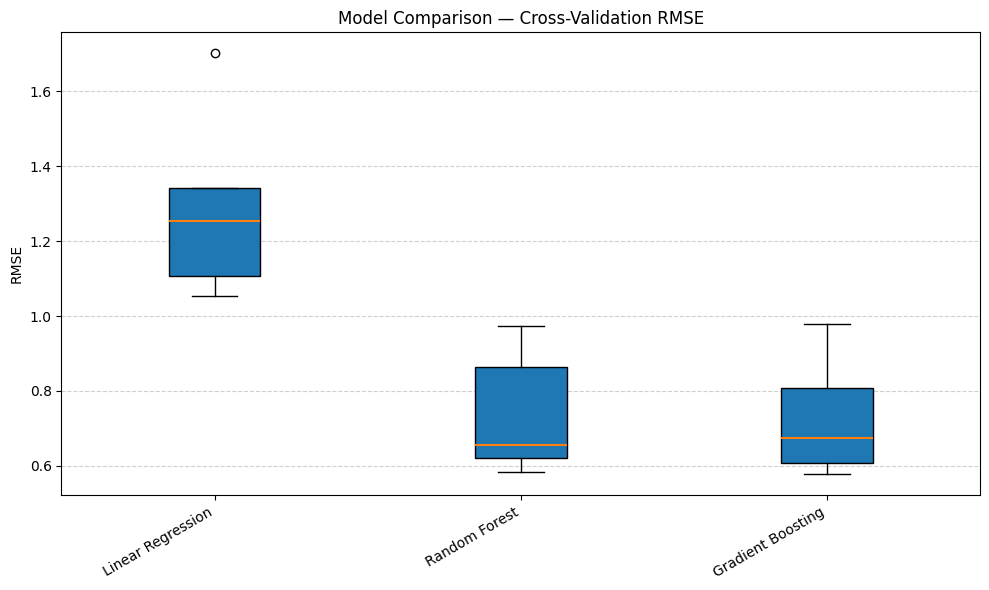

,mean_rmse,folds_mean,std,min,25%,median,75%,max
Linear Regression,1.291991,1.291991,0.256376,1.053203,1.107473,1.254384,1.343263,1.701632
Random Forest,0.738800,0.738800,0.170682,0.582446,0.619696,0.654306,0.864118,0.973435
Gradient Boosting,0.728691,0.728691,0.165093,0.577320,0.607697,0.673242,0.806969,0.978227


In [ ]:
# Visualization of cross-validation results

import matplotlib.pyplot as plt
from IPython.display import display

if 'cv_results_df' not in globals() or cv_results_df.empty:
    print("cv_results_df is empty or not defined. Make sure Step 5 ran successfully and produced results.")
else:
    # Prepare data for plotting
    labels = list(cv_results_df.columns)
    data_to_plot = [cv_results_df[col].dropna().values for col in labels]

    plt.figure(figsize=(10, 6))
    box = plt.boxplot(data_to_plot, labels=labels, patch_artist=True, medianprops={'linewidth':1.5})
    plt.title("Model Comparison — Cross-Validation RMSE")
    plt.ylabel("RMSE")
    plt.xticks(rotation=30, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Numeric summary table
    summary = cv_results_df.describe().T
    summary['mean_rmse'] = cv_results_df.mean()
    summary = summary[['mean_rmse', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']] \
              .rename(columns={'mean': 'folds_mean', '50%': 'median'})
    display(summary)


In [ ]:
# Select best model from CV, fit on full training set and evaluate on hold-out test set

from sklearn.metrics import mean_squared_error
import numpy as np

if 'cv_results_df' not in globals() or cv_results_df.empty:
    raise RuntimeError("cv_results_df is empty or missing. Run Step 5 successfully before Step 7.")

# choose the model with smallest mean CV RMSE
mean_rmse = cv_results_df.mean()
best_model_name = mean_rmse.idxmin()
print("Best model (lowest mean CV RMSE):", best_model_name)
print(mean_rmse.sort_values())

# sanity checks for test set
if 'X_test' not in globals() or 'y_test' not in globals():
    raise NameError("X_test and y_test must be defined to evaluate the chosen model.")

# Fit the pipeline (from Step 5) on full training data
best_pipeline = pipelines[best_model_name]
best_pipeline.fit(X_train, y_train)

# Predict and compute RMSE on test set
y_pred = best_pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE for {best_model_name}: {test_rmse:.4f}")

# Optional: if the final model exposes feature importances (tree-based),
# attempt to show the top features. This requires getting feature names from the preprocessor.
try:
    final_model = best_pipeline.named_steps['model']
    if hasattr(final_model, "feature_importances_"):
        # Get transformed feature names (sklearn >= 1.0 supports get_feature_names_out on ColumnTransformer)
        pre = best_pipeline.named_steps['preprocessor']
        try:
            feature_names = []
            if pre != 'passthrough':
                feature_names = pre.get_feature_names_out()
            else:
                feature_names = X_train.columns.tolist()
        except Exception:
            # fallback: can't retrieve feature names
            feature_names = [f"f{i}" for i in range(len(final_model.feature_importances_))]

        importances = final_model.feature_importances_
        idx = np.argsort(importances)[::-1]
        top_n = min(20, len(importances))
        print("\nTop feature importances:")
        for i in idx[:top_n]:
            name = feature_names[i] if i < len(feature_names) else f"f{i}"
            print(f"{name:40s} {importances[i]:.6f}")
except Exception:
    # not all models or preprocessors support this - ignore silently
    pass


Best model (lowest mean CV RMSE): Gradient Boosting
Gradient Boosting    0.728691
Random Forest        0.738800
Linear Regression    1.291991
dtype: float64
Test RMSE for Gradient Boosting: 0.5762

Top feature importances:
num__atemp                               0.980742
num__casual                              0.006761
num__humidity                            0.004272
num__windspeed                           0.003663
num__season                              0.000974
cat__datetime_2012-08-17 00:00:00        0.000381
cat__datetime_2012-08-17 01:00:00        0.000354
cat__datetime_2012-08-17 02:00:00        0.000341
cat__datetime_2012-08-17 05:00:00        0.000308
cat__datetime_2012-08-17 07:00:00        0.000302
cat__datetime_2012-08-17 03:00:00        0.000297
cat__datetime_2012-08-17 04:00:00        0.000280
cat__datetime_2012-08-17 08:00:00        0.000261
cat__datetime_2012-08-17 23:00:00        0.000258
cat__datetime_2012-08-17 06:00:00        0.000245
cat__datetime_2012-08-17 22